In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap

from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, f1_score, ConfusionMatrixDisplay

from config import DATA_DIR
from preprocessing import _downcast_dtypes, binarize_ema

# Data loading and preprocessing

In [2]:
def load_user():
    df = pd.read_csv(DATA_DIR + f"per_user/.output/30min/.dailyAggregates0_30min_data.csv")
    df = df.replace([np.inf, -np.inf], np.nan)
    return _downcast_dtypes(df)

In [3]:
df = load_user()

Downcast saved  50.00%


In [4]:
df["stress_amax"] = df["stress_amax"].replace([1, 2, 3, 4], 0) #7858 (73.81%)
df["stress_amax"] = df["stress_amax"].replace([5, 6, 7], 1) #4457 (36.19%)

In [5]:
# shift labels -1, so we predict next-day stress
y = df["stress_amax"].copy().shift(-1, fill_value=np.nan)
# last label is now np.nan and needs to be dropped
y = y.dropna()

In [6]:
X = df.drop(columns=["key", "stress_amax"])
X = X.drop(index=df.shape[0]-1)


In [7]:
X = X.drop(columns=["ema_completion_hour_amax"])

In [8]:
def create_random_samples(X, y, train_size=1000, seed=0, balanced_test=True):
    random.seed(seed)
    one_class_size = int(train_size / 2)
    all_one_indexes = [i for i, x in enumerate(y) if x == 1]
    all_zero_indexes = [i for i, x in enumerate(y) if x == 0]
    ones = random.sample(all_one_indexes, one_class_size)
    zeros = random.sample(all_zero_indexes, one_class_size)
    train_indexes = random.sample(ones+zeros, train_size)
    new_x = X.iloc[train_indexes]
    new_y = y.iloc[train_indexes]
    if balanced_test == False:
        test_indexes = [i for i in range(len(y)) if i not in train_indexes]
        test_x = X.iloc[test_indexes]
        test_y = y.iloc[test_indexes]
    else:
        not_used_ones = list(set(all_one_indexes) - set(ones))
        not_used_zeros = list(set(all_zero_indexes) - set(zeros))
        test_sample_size = min(len(not_used_ones), len(not_used_zeros))
        test_ones = random.sample(not_used_ones, test_sample_size)
        test_zeros = random.sample(not_used_zeros, test_sample_size)
        test_indexes = random.sample(test_ones+test_zeros, test_sample_size*2)
        test_x = X.iloc[test_indexes]
        test_y = y.iloc[test_indexes]
    
    return new_x, new_y, test_x, test_y

In [9]:
# create balanced training and test set
X_train, y_train, X_test, y_test = create_random_samples(X, y, train_size=6000, seed=0, balanced_test=True)

In [16]:
# function to compute Accuracy, F1 score, and confusion matric of a model
def benchmark_model(model, X_test, y_test):
    print(f"N test cases: {len(y_test)}")
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize="true")

    print("Accuracy on test data:", accuracy_score(y_test, y_pred))
    print("F1 on test data:", f1_score(y_test, y_pred))
    print("Confusion matrix on test data:", cm)

    
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stressed", "Not stressed"])
    plot_confusion_matrix(model, X_test, y_test, cmap="YlOrRd", display_labels=["Stressed", "Not stressed"])
    #disp.plot(cmap="YlOrRd")
    #disp.im_.set_clim(0, 1)
    
    #plt.savefig('./figures/confusion_matrix_reduced1_final.png', format="png", dpi=300, bbox_inches='tight', transparent=False)
    

In [ ]:
# plot the dictionary from one XGBoost fit iteration
def plot_evals_metric(model):
    evals_dict = model.evals_result()
    train_evals = evals_dict["validation_0"]
    val_evals = evals_dict["validation_1"]

    for metric in train_evals:
        plt.figure()
        plt.title(metric)
        plt.plot(train_evals[metric], label="training")
        plt.plot(val_evals[metric], label="validation")
        plt.legend()
        plt.show()

        print(f"Best validation {metric}: {np.max(val_evals[metric])}")

# Manual Implementation

In [ ]:
"""
Booster param
learning_rate= #alias eta; from 0 to 1; usually 0.01 to 0.2
min_split_loss= #alias gamma; from 0 to inf
max_depth= #from 0 to inf; usually 3 to 10; too high can overfit
min_child_weight= #from 0 to inf; too high can underfit
max_delta_step= #from 0 to inf; mainly useful for logistic regression with imbalanced class
subsample= #subsample data; from 0 to 1; usually 0.5 to 1
colsample_by = #subsample columns; from 0 to 1; 
reg_lambda= #alias lambda; L2 reg; high value is conservative
reg_alpha= #alias alpha; L1 reg; useful for high dimensionality

Learning param
objective= #loss function; binary:logistic; outputs probability
eval_metric= #metric used for validation; error for classification; also auc
"""


In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc", "logloss"]

In [ ]:
clf = xgb.XGBClassifier(
    seed=0,
    objective="binary:logistic",
    tree_method="hist",
    nthread=8,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.8,
    min_split_loss=18
    )

In [ ]:
clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
plot_evals_metric(clf)

In [ ]:
benchmark_model(clf, X_test, y_test)

In [ ]:
# dataframe of most important XGBoost features
# NOT EQUIVALENT to highest SHAP value
pd.DataFrame({'Variable': X.columns,
              'Importance': clf.feature_importances_}).sort_values('Importance', ascending=False)

# Optuna Implementation

In [ ]:
def optuna_objective(trial):
    optuna_params = {
        "seed": 0,
        "verbosity": 1,
        "objective": "binary:logistic",
        "n_estimators": 100,
        "tree_method": "hist",
        "nthread": 8,
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.1, 100),
        "subsample": trial.suggest_categorical("subsample", [0.6, 0.7, 0.8, 0.9, 1.0]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.6, 0.7, 0.8, 0.9, 1.0]),
        "max_depth": trial.suggest_int("max_depth", 3, 14, step=1),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 8, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        # defines how selective algorithm is.
        "min_split_loss": trial.suggest_int("min_split_loss", 4, 16, step=2),
        "grow_policy": "depthwise" #trial.suggest_categorical("grow_policy", ["lossguide", "depthwise"])
    }


    optuna_clf = xgb.XGBClassifier(**optuna_params)
    optuna_clf.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=False
    )
    
    
    #validation_eval_metric = optuna_clf.evals_result()["validation_1"]["logloss"]

    #return np.min(validation_eval_metric)

    return accuracy_score(y_test, optuna_clf.predict(X_test))

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=50, timeout=600)
print("Number of finished trials: ", len(study.trials))

In [ ]:
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
optuna_clf = xgb.XGBClassifier(**study.best_params)

In [ ]:
optuna_clf.fit(X_train, y_train, eval_metric='logloss')

In [ ]:
benchmark_model(optuna_clf, X_test, y_test)

# Best model

In [ ]:
# built on the dataset #0 containing 188 features
full_params = {
    "seed": 0,
    "verbosity": 1,
    "objective": "binary:logistic",
    "n_estimators": 100,
    "tree_method": "hist",
    "nthread": 8,
    "reg_lambda": 2.2301519862337026e-07,
    "reg_alpha": 0.01,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "max_depth": 8,
    "min_child_weight": 3,
    "learning_rate": 0.06665297393146022,
    "min_split_loss": 10
    }

In [11]:
# built on the dataset #0 containing 187 features (no ema hour)
full2_params = {
  "seed": 0,
  "verbosity": 1,
  "objective": "binary:logistic",
  "n_estimators": 100,
  "tree_method": "hist",
  "nthread": 8,
  "reg_lambda": 9.988546722919172e-08,
  "reg_alpha": 0.8633567012476167,
  "subsample": 0.9,
  "colsample_bytree": 0.7,
  "max_depth": 14,
  "min_child_weight": 3,
  "learning_rate": 0.0011450536370580524,
  "min_split_loss": 4
}

In [ ]:
# built on the dataset #1 containing 33 features
reduced1_params = {
  "seed": 0,
  "verbosity": 1,
  "objective": "binary:logistic",
  "n_estimators": 100,
  "tree_method": "hist",
  "nthread": 8,
  "reg_lambda": 4.70506437545129e-05,
  "reg_alpha": 0.5448312828110815,
  "subsample": 0.8,
  "colsample_bytree": 0.8,
  "max_depth": 11,
  "min_child_weight": 7,
  "learning_rate": 0.013478797877106216,
  "min_split_loss": 6
}

In [ ]:
# built on the dataset #2 containing 57 features
reduced2_params = {
    "seed": 0,
    "verbosity": 1,
    "objective": "binary:logistic",
    "n_estimators": 150,
    "tree_method": "hist",
    "nthread": 8,
    "reg_lambda": 1.1994748914057228e-08,
    "reg_alpha": 0.1,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "max_depth": 7,
    "min_child_weight": 4,
    "learning_rate": 0.05492940803299358,
    "min_split_loss": 4
}

In [12]:
best_clf = xgb.XGBClassifier(**full2_params)

In [13]:
best_clf.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=["logloss"],
    verbose=False
    )

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0011450536370580524, max_delta_step=0,
              max_depth=14, min_child_weight=3, min_split_loss=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8, nthread=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0.8633567012476167,
              reg_lambda=9.988546722919172e-08, scale_pos_weight=1, seed=0,
              subsample=0.9, tree_method='hist', validate_parameters=1,
              verbosity=1)

N test cases: 2914
Accuracy on test data: 0.6190803019903912
F1 on test data: 0.6267652992602555
Confusion matrix on test data: [[0.59849005 0.40150995]
 [0.36032944 0.63967056]]


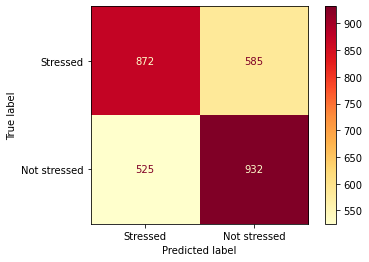

In [17]:
benchmark_model(best_clf, X_test, y_test)

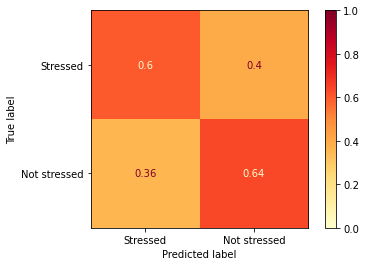

In [18]:
_y_pred = best_clf.predict(X_test)
_cm = confusion_matrix(y_test.copy(), _y_pred, normalize="true")    
_disp = ConfusionMatrixDisplay(confusion_matrix=_cm, display_labels=["Stressed", "Not stressed"])
_disp.plot(cmap="YlOrRd")
_disp.im_.set_clim(0, 1)
plt.savefig('./figures/confusion_matrix_reduced_FINALLY.png', format="png", dpi=300, bbox_inches='tight', transparent=False)

# SHAP 

In [ ]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_train)
shap_obj = explainer(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, show=False, max_display=10)
#plt.savefig("./figures/xgb_beeswarm_full2.png", format="png", dpi=300, bbox_inches='tight', transparent=False)

In [ ]:
shap.plots.waterfall(shap_obj[12], show=False)
#plt.savefig("./figures/xgb_user19.png", format="png", dpi=300, bbox_inches='tight', transparent=False)